In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from DataRead import data_read
from OriginModel import *
import time
import numpy as np
from cdan import DomainDiscriminator, ConditionalDomainAdversarialLoss



In [2]:
## hyper parameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IsSave = False
feature_dim = 2048
num_classes = 34
epoch = 30
batch_size = 32
learning_rate = 0.0001
interval=100
optimizer='adam'
num_k=4
save_epoch=10
seed = 1
datapath = '/home/zsc/ADS_B_select_files_/dataset/noise_64x64_202004xx_to_202011xx.h5'
stime = str(time.asctime( time.localtime(time.time()) )).split(' ')
record_file = './record/'+ stime[-4]+stime[-3]+ '_' +stime[-2]
print(record_file)

./record/3_14:59:36


In [3]:
datasets, dataset_test = data_read(batch_size,datapath)

discriminator = DomainDiscriminator(in_feature=feature_dim * num_classes, hidden_size=1024).to(device)
cond_loss = ConditionalDomainAdversarialLoss(discriminator, reduction='mean').to(device)
G = Feature().to(device)
C1 = Predictor(num_classes=num_classes).to(device)

# C2 = Predictor(num_classes=num_classes).to(device)

opt_g = optim.Adam(G.parameters(),lr=learning_rate, weight_decay=0.0005)
opt_c1 = optim.Adam(C1.parameters(),lr=learning_rate, weight_decay=0.0005)
# opt_c2 = optim.Adam(C2.parameters(),lr=learning_rate, weight_decay=0.0005)

In [4]:
def entropy(predictions: torch.Tensor, reduction='none') -> torch.Tensor:
    epsilon = 1e-5
    H = -predictions * torch.log(predictions + epsilon)
    H = H.sum(dim=1)
    if reduction == 'mean':
        return H.mean()
    else:
        return H

def discrepancy(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1,dim=1) - F.softmax(out2,dim=1)))

def mccLoss(logits: torch.Tensor,temperature=1) -> torch.Tensor:
    batch_size, num_classes = logits.shape
    predictions = F.softmax(logits / temperature, dim=1)  # batch_size x num_classes
    entropy_weight = entropy(predictions).detach()
    entropy_weight = 1 + torch.exp(-entropy_weight)
    entropy_weight = (batch_size * entropy_weight / torch.sum(entropy_weight)).unsqueeze(dim=1)  # batch_size x 1
    class_confusion_matrix = torch.mm((predictions * entropy_weight).transpose(1, 0), predictions) # num_classes x num_classes
    class_confusion_matrix = class_confusion_matrix / torch.sum(class_confusion_matrix, dim=1)
    mcc_loss = (torch.sum(class_confusion_matrix) - torch.trace(class_confusion_matrix)) / num_classes
    return mcc_loss

def get_L2norm_loss_self_driven(x, radius = 25., weight_L2norm= 0.05):
    l = (x.norm(p=2, dim=1).mean() - radius) ** 2
    return weight_L2norm * l
  


In [5]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
bestacc = 0
bestmat = np.zeros((num_classes,num_classes))
for i in range(epoch):
    criterion = nn.CrossEntropyLoss().to(device)
    G.train()
    C1.train()
    # C2.train()
    torch.cuda.manual_seed(seed)
    if (i+1) % 5 == 0:
            learning_rate /= 2
            update_lr(opt_g, learning_rate)
            update_lr(opt_c1, learning_rate)
            # update_lr(opt_c2, learning_rate)
    for batch_idx, data in enumerate(datasets):
        img_t = data['T']
        img_s = data['S']
        label_s = data['S_label'].to(device)
        img_s = img_s.to(device)
        img_t = img_t.to(device)
        opt_g.zero_grad()
        opt_c1.zero_grad()
        # opt_c2.zero_grad()
        f_s = G(img_s).to(device)
        f_t = G(img_t).to(device)
        y_s = C1(f_s).to(device)
        # output_s2 = C2(feat_s)
        y_t = C1(f_t).to(device)

        loss_s1 = criterion(y_s, label_s)
        
        transfer_loss = cond_loss(y_s, f_s, y_t, f_t)

        loss = loss_s1 + transfer_loss

        loss.backward()
        opt_g.step()
        opt_c1.step()
        # opt_c2.step()

        opt_g.zero_grad()
        opt_c1.zero_grad()
        # opt_c2.zero_grad()


        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss1: {:.6f}\t transfer_loss(cdan): {:.6f} '.format(
                    i, batch_idx, 500,
                    100. * batch_idx / 500, loss_s1.item(), transfer_loss.item()))
            if record_file:
                    with open(record_file , 'a+') as f:
                        f.write('Loss1: {:.6f}\t transfer_loss: {:.6f}\n'.format(loss_s1.item(), transfer_loss.item()))
    
    #  TEST
    G.eval()
    C1.eval()
    # C2.eval()
    test_loss = 0
    correct1 = 0

    size = 0
    
    mat = np.zeros((num_classes,num_classes))
    with torch.no_grad():
        for batch_idx, data in enumerate(dataset_test):
            img = data['T']
            label = data['T_label']
            img, label = img.to(device), label.to(device)
            feat = G(img)
            output1 = C1(feat)
            # output2 = C2(feat)
            test_loss += F.nll_loss(output1, label).item()
            pred1 = output1.data.max(1)[1]
            k = label.data.size()[0]
            correct1 += pred1.eq(label.data).cpu().sum()

            size += k
            for i,X in enumerate(pred1):
                preL = int(X.cpu().detach().numpy())
                trueL = int(label.data[i].cpu().detach().numpy())
                mat[trueL,preL] += 1
        test_loss = test_loss / size
        print('\nTest set: Average loss: {:.4f}, Accuracy : {}/{} ({:.2f}%)  \n'.format(
                test_loss, correct1, size,100. * correct1 / size))
        if 100. * correct1 / size > bestacc:
            bestacc = 100. * correct1 / size
            bestmat = mat
    if  IsSave and (i+1) % save_epoch == 0:
        torch.save(G,
                './MCDmodel/'+record_file.split('/')[-1]+'_G_mcconly.pt')
        torch.save(C1,
                './MCDmodel/'+record_file.split('/')[-1]+'_C1_mcconly.pt')
        
    if record_file:
        print('recording :', record_file)
        with open(record_file,'a+') as f:
            f.write(' Accuracy : {}/{} ({:.2f}%)\n'.format(correct1 , size,correct1 /size))

        

Train Epoch: 0 [0/500 (0%)]	Loss1: 3.761245	 transfer_loss(cdan): 0.713299 
Train Epoch: 0 [100/500 (20%)]	Loss1: 2.927601	 transfer_loss(cdan): 0.757228 
Train Epoch: 0 [200/500 (40%)]	Loss1: 1.738503	 transfer_loss(cdan): 0.831143 
Train Epoch: 0 [300/500 (60%)]	Loss1: 1.308889	 transfer_loss(cdan): 0.768899 
Train Epoch: 0 [400/500 (80%)]	Loss1: 0.691800	 transfer_loss(cdan): 0.933983 

Test set: Average loss: -0.0850, Accuracy : 7431/14395 (51.62%)  

recording : ./record/3_14:59:36
Train Epoch: 1 [0/500 (0%)]	Loss1: 0.347755	 transfer_loss(cdan): 1.070096 
Train Epoch: 1 [100/500 (20%)]	Loss1: 0.262753	 transfer_loss(cdan): 1.704906 
Train Epoch: 1 [200/500 (40%)]	Loss1: 0.207169	 transfer_loss(cdan): 2.110994 
Train Epoch: 1 [300/500 (60%)]	Loss1: 0.184097	 transfer_loss(cdan): 2.604176 
Train Epoch: 1 [400/500 (80%)]	Loss1: 0.114269	 transfer_loss(cdan): 2.699726 

Test set: Average loss: -0.0723, Accuracy : 8084/14395 (56.16%)  

recording : ./record/3_14:59:36
Train Epoch: 2 [

<AxesSubplot:>

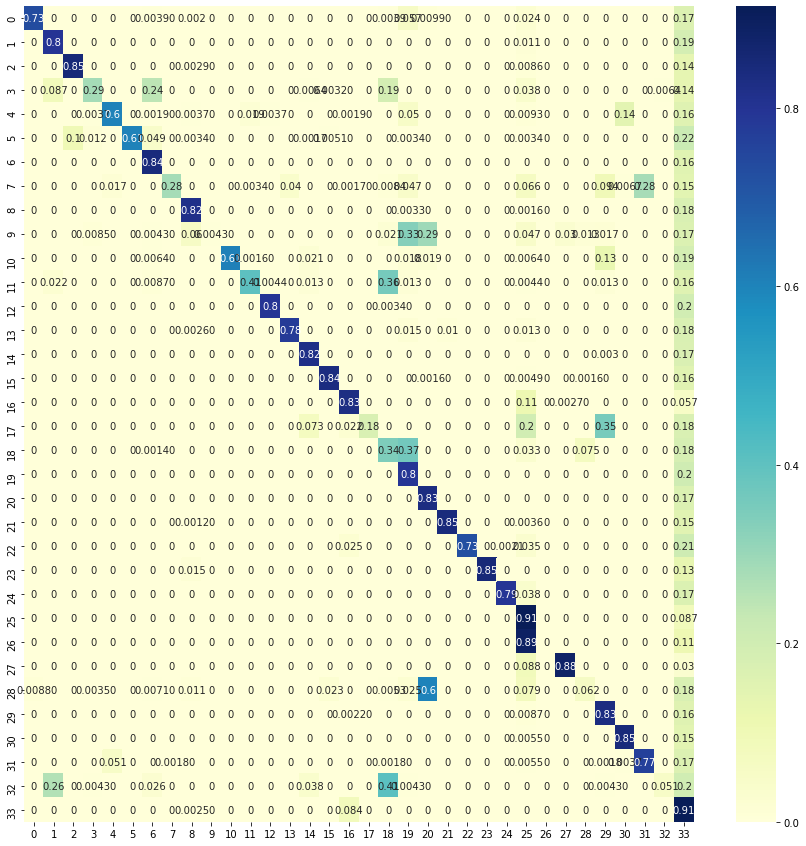

In [6]:
mat1 = bestmat/bestmat.sum(axis=1 ,keepdims = True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
sns.heatmap(data=mat1,annot=True,cmap= "YlGnBu")